# Model Evaluation: LDA + BERT Hybrid Approach
This notebook evaluates a hybrid ML pipeline combining Latent Dirichlet Allocation (LDA) and BERT for information filtering and truth validation. 

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Absolute path to project root (adjust if needed)
project_root = "/Users/haigbedros/Desktop/MSDS/Capstone/CODE/ml-models-information-filtering"
os.chdir(project_root)

print("✅ Working in:", os.getcwd())

In [1]:
# ======== data test =========
import sys
import os

from utils.utils import tfa_df, fake_df, true_df, nyt_df, book_df

# Verify the datasets
# print("TFA Sample:", tfa_df.head(2))
# print("Fake Sample:", fake_df.head(2))
# print("True Sample:", true_df.head(2))
# print("NYT Sample:", nyt_df.head(2))

# print(true_df.columns)

print("\nBook PDF Metadata DataFrame:\n", book_df.head())

KeyboardInterrupt: 

In [3]:
from tokenizer.token_counter import TokenCounter

counter = TokenCounter("gpt-3.5-turbo")

texts = [
    "The quick brown fox jumps over the lazy dog.",
    "LDA discovers hidden topics.",
    "BERT extracts deep contextual embeddings."
]

print("\nIndividual token counts:", counter.count_batch(texts))
print("Total tokens:", counter.total_tokens(texts))


Individual token counts: [10, 6, 6]
Total tokens: 22


In [7]:
from tokenizer.token_counter import TokenCounter
import pandas as pd
from utils.utils import true_df  # Import true_df from utils

# Initialize the token counter
counter = TokenCounter("gpt-3.5-turbo")

# Step 1: Count tokens in true_df
true_texts = true_df['text'].tolist()  # Replace 'subject' with the appropriate column name
true_token_counts = counter.count_batch(true_texts)
true_total_tokens = counter.total_tokens(true_texts)

print("=== Token Count for true_df ===")
print("Individual token counts:", true_token_counts)
print("Total tokens:", true_total_tokens)

# Step 2: Count tokens in processed_true.csv
processed_df = pd.read_csv("/Users/haigbedros/Desktop/MSDS/Capstone/CODE/ml-models-information-filtering/notebooks/processed_true.csv")
processed_texts = processed_df['subject'].tolist()  # Replace 'subject' with the appropriate column name
processed_token_counts = counter.count_batch(processed_texts)
processed_total_tokens = counter.total_tokens(processed_texts)

print("\n=== Token Count for processed_true.csv ===")
print("Individual token counts:", processed_token_counts)
print("Total tokens:", processed_total_tokens)

# Step 3: Calculate token reduction rate
token_reduction_rate = (true_total_tokens - processed_total_tokens) / true_total_tokens * 100
print(f"\nToken Reduction Rate: {token_reduction_rate:.2f}%")

=== Token Count for true_df ===
Individual token counts: [915, 738, 532, 464, 1066, 715, 641, 205, 166, 82, 477, 773, 149, 330, 448, 535, 879, 268, 471, 259, 660, 1145, 486, 443, 945, 447, 409, 365, 86, 517, 212, 289, 113, 395, 1419, 1015, 672, 545, 566, 111, 254, 369, 708, 83, 479, 434, 732, 431, 97, 466, 93, 1140, 826, 491, 514, 455, 268, 185, 462, 768, 558, 282, 1020, 450, 792, 772, 1638, 536, 464, 157, 322, 1677, 89, 79, 731, 1078, 939, 971, 418, 819, 545, 481, 94, 530, 138, 1781, 112, 549, 420, 99, 74, 123, 783, 422, 290, 97, 396, 643, 410, 656, 518, 1028, 100, 410, 156, 227, 490, 108, 1382, 1529, 451, 139, 84, 550, 737, 96, 94, 777, 289, 324, 369, 234, 258, 370, 453, 487, 477, 861, 719, 332, 116, 100, 99, 87, 78, 611, 494, 301, 835, 910, 348, 499, 526, 700, 488, 463, 363, 1038, 793, 87, 108, 118, 419, 90, 70, 358, 301, 328, 446, 121, 548, 734, 1122, 1261, 313, 591, 591, 622, 105, 657, 227, 526, 300, 734, 426, 1143, 302, 95, 292, 85, 85, 237, 59, 204, 942, 119, 1003, 1062, 313, 10

In [8]:
# Compare a random sample of rows from true_df and processed_true.csv
original_sample = true_df.sample(10)
processed_sample = processed_df.sample(10)

print("=== Original Data Sample ===")
print(original_sample)

print("\n=== Processed Data Sample ===")
print(processed_sample)

=== Original Data Sample ===
                                                   title  ...                date
5143   'Green' funds flush with new cash, challenges ...  ...      March 6, 2017 
13316  Bosnian Croat war criminal Praljak killed hims...  ...   December 1, 2017 
7177   Top Senate Democrat cites civil rights concern...  ...  November 18, 2016 
18582  Britain will leave EU single market, customs u...  ...    October 1, 2017 
8696   Campaign aims to register a million U.S. Musli...  ...      July 20, 2016 
743        Democrats working on independent Russia probe  ...   November 8, 2017 
14414  Pinera leads Chile election with 36 percent af...  ...  November 19, 2017 
795    U.S. commerce chief says he is likely to dives...  ...   November 6, 2017 
9730   Brady Campaign's ad draws ire of U.S. anti-gun...  ...     April 29, 2016 
16880    North Korea says to continue nuclear tests: RIA  ...   October 20, 2017 

[10 rows x 4 columns]

=== Processed Data Sample ===
               

Topic Distribution in Processed Data:
topic
1    5384
2    4744
0    4112
4    4037
3    3140
Name: count, dtype: int64


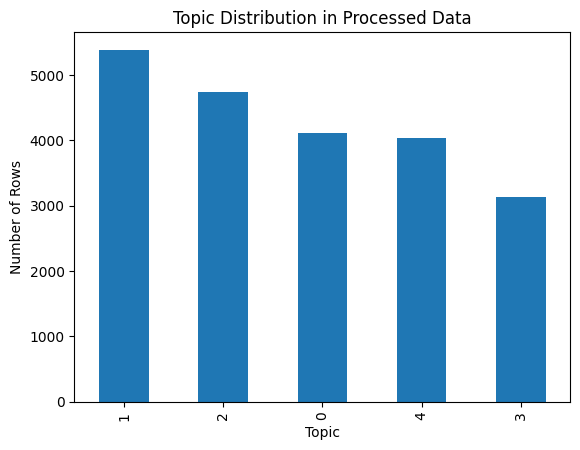

In [9]:
# Analyze topic distribution in processed_true.csv
topic_counts = processed_df['topic'].value_counts()
print("Topic Distribution in Processed Data:")
print(topic_counts)

# Visualize the topic distribution
import matplotlib.pyplot as plt

topic_counts.plot(kind='bar')
plt.title("Topic Distribution in Processed Data")
plt.xlabel("Topic")
plt.ylabel("Number of Rows")
plt.show()

In [25]:
from tokenizer.token_counter import TokenCounter
import pandas as pd
from PyPDF2 import PdfReader

# Initialize the token counter
counter = TokenCounter("gpt-3.5-turbo")

# Step 1: Count tokens in the original PDF file
def count_tokens_from_pdf(file_path: str) -> int:
    """
    Extract text from a PDF file and count tokens.
    
    Args:
        file_path (str): Path to the PDF file.
    
    Returns:
        int: Total token count in the PDF file.
    """
    reader = PdfReader(file_path)
    pdf_texts = [page.extract_text() for page in reader.pages if page.extract_text()]  # Extract text from each page
    total_tokens = counter.total_tokens(pdf_texts)
    return total_tokens

# Example: Count tokens in the original PDF file
pdf_file_path = "/Users/haigbedros/Desktop/MSDS/Capstone/CODE/ml-models-information-filtering/src/Extending the Linear Model with R.pdf"
original_pdf_total_tokens = count_tokens_from_pdf(pdf_file_path)

print("=== Token Count for Original PDF File ===")
print(f"Total tokens in original PDF file: {original_pdf_total_tokens}")

# Step 2: Count tokens in the processed PDF file
processed_pdf_path = "/Users/haigbedros/Desktop/MSDS/Capstone/CODE/ml-models-information-filtering/notebooks/processed_pdf.csv"
processed_pdf_df = pd.read_csv(processed_pdf_path)

# Ensure the processed DataFrame has a 'text' column
if 'text' not in processed_pdf_df.columns:
    raise ValueError("The processed PDF file must have a 'text' column.")

processed_pdf_texts = processed_pdf_df['text'].dropna().tolist()  # Extract text from the 'text' column
processed_pdf_total_tokens = counter.total_tokens(processed_pdf_texts)

print("\n=== Token Count for Processed PDF File ===")
print(f"Total tokens in processed PDF file: {processed_pdf_total_tokens}")

# Step 3: Calculate token reduction rate
pdf_token_reduction_rate = (original_pdf_total_tokens - processed_pdf_total_tokens) / original_pdf_total_tokens * 100
print(f"\nPDF Token Reduction Rate: {pdf_token_reduction_rate:.2f}%")

=== Token Count for Original PDF File ===
Total tokens in original PDF file: 173288

=== Token Count for Processed PDF File ===
Total tokens in processed PDF file: 84810

PDF Token Reduction Rate: 51.06%


In [ ]:
# ======== lda test =========
# need to refine and improve the process of removing less imformative words

import pandas as pd

from models.lda_model import LDAModel  # Import the LDAModel class

# Call your data from here
df = true_df
text_column = 'text'  # Column name containing the text data

# Initialize the LDA model
lda_model = LDAModel(n_components=5, random_state=42)

# Fit the model on the DataFrame
lda_model.fit(df, text_column=text_column)

# Print the top words for each topic
lda_model.print_topics(n_top_words=5)

# Transform the documents to topic distributions
doc_topic_dist = lda_model.transform(df, text_column=text_column)

# Display the topic distribution for each document
for i, topic_dist in enumerate(doc_topic_dist):
    print(f"Document {i} topic distribution: {topic_dist}")


Topic 0:  said | court | government | party | reuters
Topic 1:  said | trump | house | president | senate
Topic 2:  said | reuters | government | state | people
Topic 3:  trump | said | clinton | republican | campaign
Topic 4:  said | trump | united | china | north
Document 0 topic distribution: [4.87898254e-04 9.98050539e-01 4.84375760e-04 4.90437618e-04
 4.86748992e-04]
Document 1 topic distribution: [0.55963686 0.31764986 0.00057177 0.00057339 0.12156813]
Document 2 topic distribution: [0.00085081 0.69631544 0.00084805 0.2150552  0.0869305 ]
Document 3 topic distribution: [0.02096311 0.65820411 0.07599092 0.17358476 0.0712571 ]
Document 4 topic distribution: [4.35095469e-04 9.88941447e-01 4.34806606e-04 9.75312854e-03
 4.35522310e-04]
Document 5 topic distribution: [2.93562471e-02 9.16965041e-01 5.76905801e-04 5.25223655e-02
 5.79440478e-04]
Document 6 topic distribution: [0.00068711 0.33584117 0.00068707 0.3646587  0.29812595]
Document 7 topic distribution: [0.00248869 0.5384747  0